# 压缩感知

压缩感知（稀疏表示）：
$$
\min_{x\in {\mathbb R}^n}\frac12 \|Ax-b\|_2^2+\lambda\|x\|_1
$$
其中感知矩阵$A\in {\mathbb R}^{m\times n}$(通常是一个随机矩阵), 观察向量$b\in {\mathbb R}^n$， 正则参数$\lambda>0$.

参考文献

[1] 叶颀, 谭露琳, 刘春光, 林荣荣，陈艳楠, 胡耀华.《最优化方法与机器学习》, 科学出版社“十四五”普通高等教育规划教材, 2025，第198-203页

[2] Prater-Bennette A, Shen L, Tripp E E. The proximity operator of the log-sum penalty[J]. Journal of Scientific Computing, 2022, 93(3): 67.

# 目录

1. 模拟数据集

2. 以PIE稀疏罚函数为例

3. 不同的稀疏罚函数对比

4. 不同算法对比

5. 练习

# Python包

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import rand
from tqdm import tqdm
import time
from sklearn.preprocessing import normalize

import warnings
warnings.filterwarnings('ignore')

#压缩包里面的三个文件prox,other_func,Algo需要加载
from prox import *
from other_func import *
from Algo import *

# 1 模拟数据集

$128\times1024$的随机高斯测量矩阵A,并进行列归一化

In [2]:
#Gaussian random measurement matrix
m = 128
n = 1024
A = np.random.normal(0, 1, (m, n))

print('before normalization:',1/np.linalg.norm(A,2)**2)
# normalize columns of matrix A
A = normalize(A, axis=0, norm='l2')

print('after normalization:',1/np.linalg.norm(A,2)**2)

corr = A.T.dot(A)
for i in range(1024):
    corr[i][i] = 0
abs(corr).max()

before normalization: 0.0005506806271243289
after normalization: 0.07070221307624851


0.4101402677276119

In [3]:
e,v = np.linalg.eig(A.T.dot(A))
maxiter = 20000
error = 1e-5
k_list = np.linspace(4,60,15) #稀疏k=4,8,12,....60
x_index = [i for i in range(n)]

# 2 以PIE稀疏罚函数为例

选取$\lambda = 0.02$, $\sigma = 2$, $\mu = 0.99\mu_{max}$, $k=45$

Running time: 0.953125
relative error: 0.006032587427766923


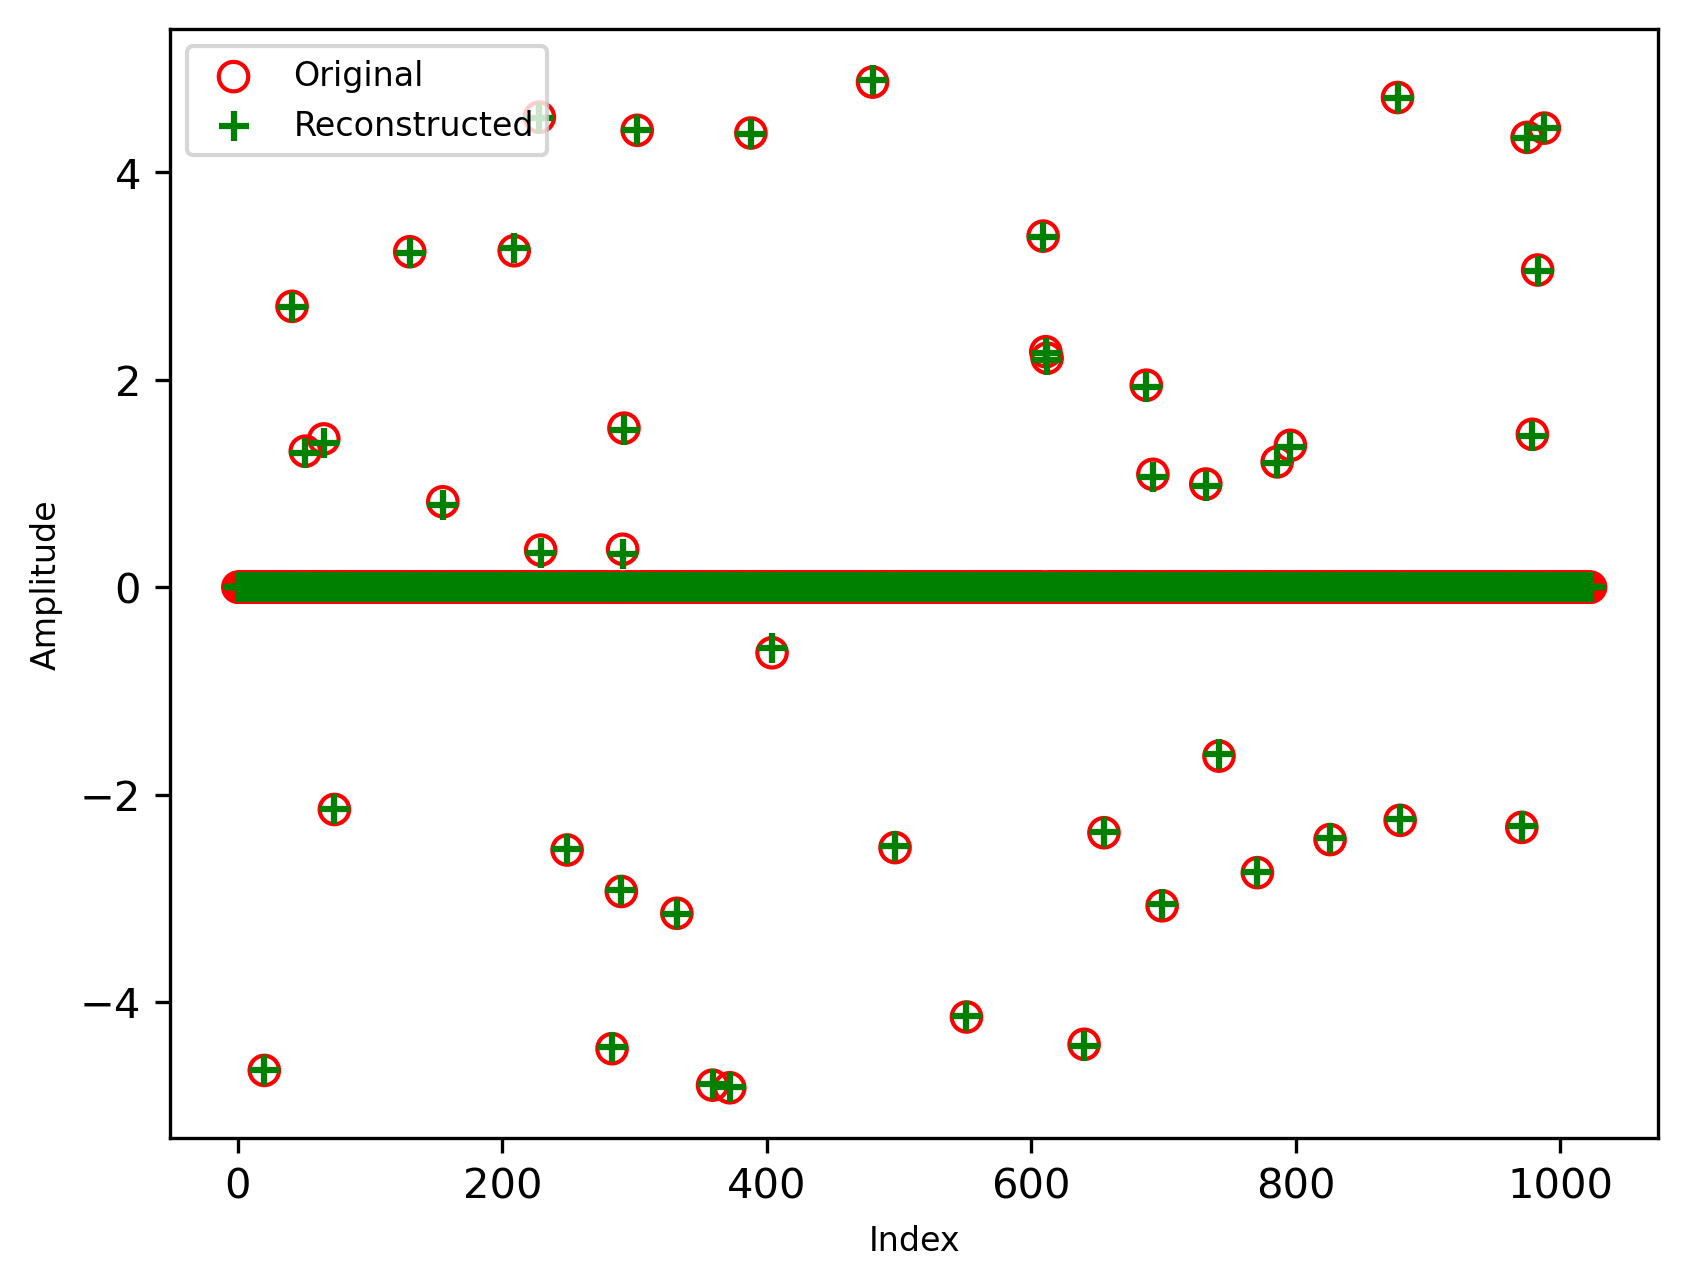

In [13]:
k = 45
Lambda = 0.05
sigma = 2

L=np.linalg.norm(A,2)**2
mu = 0.99*2/(L+Lambda/sigma**2)
for ww in range(100):
    x_true = rand(n,1,k/n).toarray()
    x_true[x_true != 0 ] = 10*(x_true[x_true != 0 ]-0.5)
    b = A.dot(x_true)
    b_noise = b
    Ab = A.T.dot(b_noise)
    AA = A.T.dot(A)
    
    t0 = time.process_time()
    temp = mu*Lambda/sigma**2
    if temp<=1:
        x,i=ISTA(A, b, mu, shrinkage_PiE_soft, sigma, Lambda, maxiter,error)
    else:
        x,i=ISTA(A, b, mu, PiEProximalbyLambertWThreshold, sigma, Lambda, maxiter,error)
    if np.linalg.norm(x-x_true)/np.linalg.norm(x_true)<0.01:
        print("Running time:",time.process_time() - t0)
        print('relative error:',np.linalg.norm(x-x_true)/np.linalg.norm(x_true))
        plt.figure()
        plt.scatter(x_index,x_true,color='none',marker='o' ,label='Original',edgecolors='r', s=50)
        plt.rcParams['figure.dpi'] = 600 #分辨率
        plt.scatter(x_index,x,marker='+',label='Reconstructed',color='g',s=50)
        plt.xlabel('Index',fontsize=8)
        plt.ylabel('Amplitude',fontsize=8)
        plt.legend(loc='upper left',fontsize = 8) 
        plt.show()
        break

# 3 不同的稀疏罚函数对比

### under $0.99*\mu_{max}$.


\begin{array}{|c|c|c|c|c|c|c|c|c|c|c|c|} \hline
Penalties & PiE &Log & CaP & TL1 & SCAD & MCP & \ell_0 & \ell_1 &\ell_{1/2} &\ell_1-\ell_2 &\ell_1/\ell_2 \\ \hline
 &\lambda=0.05  &\lambda=0.02  &\lambda=0.02  &\lambda=0.02  &\lambda=0.2  &\lambda=0.2  &\lambda=0.9 &\lambda=0.02   &\lambda=0.1 &\lambda=0.01 &\lambda=0.01\\  
Parameters  &\sigma=2  &a=1  &a=1 &a=2 &a=20  &a=19  & -  & -   & - &a=1 & -\\  
           &\mu=0.99\!\frac{2}{\nu_{\max}+\frac{\lambda}{\sigma^2}}
           &\mu=0.99\!\frac{2}{\nu_{\max}+\frac{\lambda}{a^2}}
           &\mu=0.99\!\frac{2}{\nu_{\max}}
           &\mu=0.99\!\frac{2}{\nu_{\max}+\frac{2(a+1)\lambda}{a^2}}
           &\mu=0.99\!\frac{2}{\nu_{\max}+\frac{1}{a-1}}
           &\mu=0.99\!\frac{2}{\nu_{\max}+\frac{1}{a}}
&\mu=0.99\!\frac{2}{\nu_{\max}}
&\mu=0.99\!\frac{2}{\nu_{\max}}
&\mu=0.99\!\frac{2}{\nu_{\max}}
&\mu=0.99\!\frac{2}{\nu_{\max}+2a}
&\mu=0.99\!\frac{2}{\nu_{\max}}
\\ \hline
\end{array}




In [4]:
shrinkage_list = [_,_,_,shrinkage_TL1,shrinkage_hard,shrinkage_soft,shrinkage_half,shrinkage_scad,shrinkage_mcp,shrinkage_l1_2,shrinkage_l1overl2]
#               PiE   Log    cap   TL1   hard  soft   half  scad   mcp   L1-L2    L1/L2
lambda_list = [0.05, 0.02, 0.02 , 0.02,  0.9 , 0.01,   0.1 , 0.2,  0.2 , 0.01 ,  0.2 ]
a_list      = [ 2  ,   1 ,   1  ,  2  ,   0  ,   0 ,   0   , 20 ,  19  ,  1   ,   0  ]
mu_ = 0.99

mu_pie = mu_*(2/(max(e).real+lambda_list[0]/(a_list[0]**2)))
mu_scad= mu_*(2/(max(e).real+1/(a_list[7]-1)))
mu_mcp = mu_*(2/(max(e).real+1/(a_list[8])))
mu_log = mu_*(2/(max(e).real+lambda_list[1]/(a_list[1]**2)))
mu_tl1 = mu_*(2/(max(e).real+2*(a_list[3]+1)*lambda_list[3]/(a_list[3]**2)))
mu_L1_L2 = mu_*(2 /( max(e).real+2*a_list[9]))
mu     = mu_*(2 / max(e).real)

mu_list = [mu_pie,mu_log,mu,mu_tl1,mu,mu,mu,mu_scad,mu_mcp,mu_L1_L2,mu]
k_list = np.linspace(4,60,15)
x_index = [i for i in range(n)]

avgtime_99 = np.zeros((len(k_list),len(shrinkage_list)))
success_99 = np.zeros((len(k_list),len(shrinkage_list)))
numiter_99 = np.zeros((len(k_list),len(shrinkage_list)))
for index_k, k in enumerate(k_list):
    p = k/n
    
    total_time = np.zeros((1,len(shrinkage_list)))
    total_num = np.zeros((1,len(shrinkage_list)))
    for j in tqdm(range(100)):
        x_true = rand(n,1,p).toarray()
        x_true[x_true != 0 ] = 10*(x_true[x_true != 0 ]-0.5)
        b = A.dot(x_true)
        
        #pie
        t0 = time.process_time()
        temp = mu_pie*lambda_list[0]/a_list[0]**2
        if temp<=1:
            x,num=ISTA(A,b,mu_list[0],shrinkage_PiE_soft,a_list[0],lambda_list[0],maxiter,error)
        else:
            x,num=ISTA(A,b,mu_list[0],PiEProximalbyLambertWThreshold,a_list[0],lambda_list[0],maxiter,error)
        if Error(x,x_true)<0.01:
            success_99[index_k][0] += 0.01
        total_time[0][0] += time.process_time()-t0
        total_num[0][0] += num
        
        #log
        t0 = time.process_time()
        if np.sqrt(lambda_list[1])<=a_list[1]:
            x,num=ISTA(A,b,mu_list[1],shrinkage_log_soft,a_list[1],lambda_list[1],maxiter,error)
        else:
            x,num=ISTA(A,b,mu_list[1],shrinkage_log_hard,a_list[1],lambda_list[1],maxiter,error) 
        if Error(x,x_true)<0.01:
            success_99[index_k][1] += 0.01
        total_time[0][1] += time.process_time()-t0
        total_num[0][1] += num
        
        #cap
        t0 = time.process_time()
        if lambda_list[2]<=2*a_list[2]:
            x,num=ISTA(A,b,mu_list[2],shrinkage_CaP_soft,a_list[2],lambda_list[2],maxiter,error)
        else:
            x,num=ISTA(A,b,mu_list[2],shrinkage_CaP_hard,a_list[2],lambda_list[2],maxiter,error)
        if Error(x, x_true)<0.01:
            success_99[index_k][2] += 0.01
        total_time[0][2] += time.process_time()-t0 
        total_num[0][2] += num
        
        for i in range(3,11):
            t0 = time.process_time()
            x,num=ISTA(A,b,mu_list[i],shrinkage_list[i],a_list[i],lambda_list[i],maxiter,error)
            if Error(x, x_true)<0.01:
                success_99[index_k][i] += 0.01
            total_time[0][i] += time.process_time()-t0 
            total_num[0][i] += num
    avgtime_99[index_k] = total_time/100
    numiter_99[index_k] = total_num/100

100%|██████████| 100/100 [49:42<00:00, 29.83s/it]


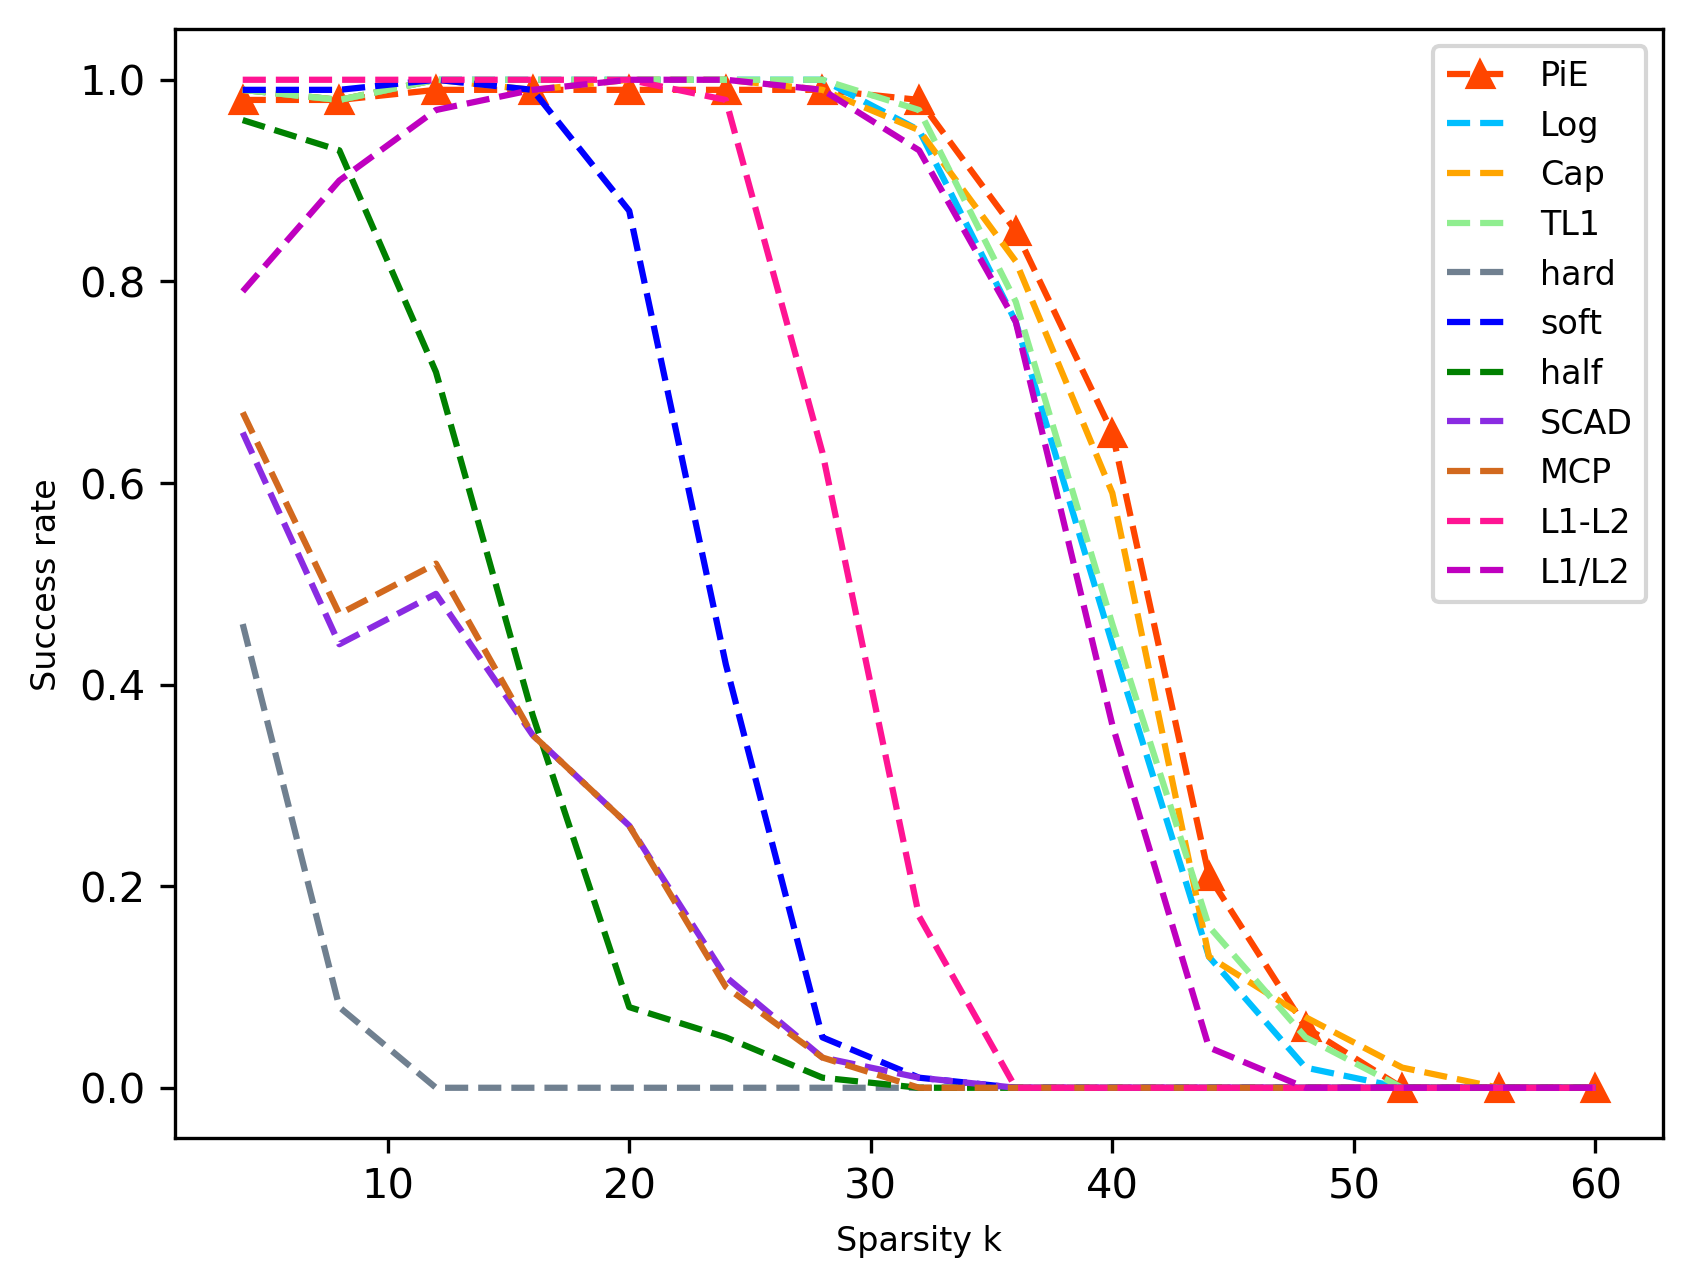

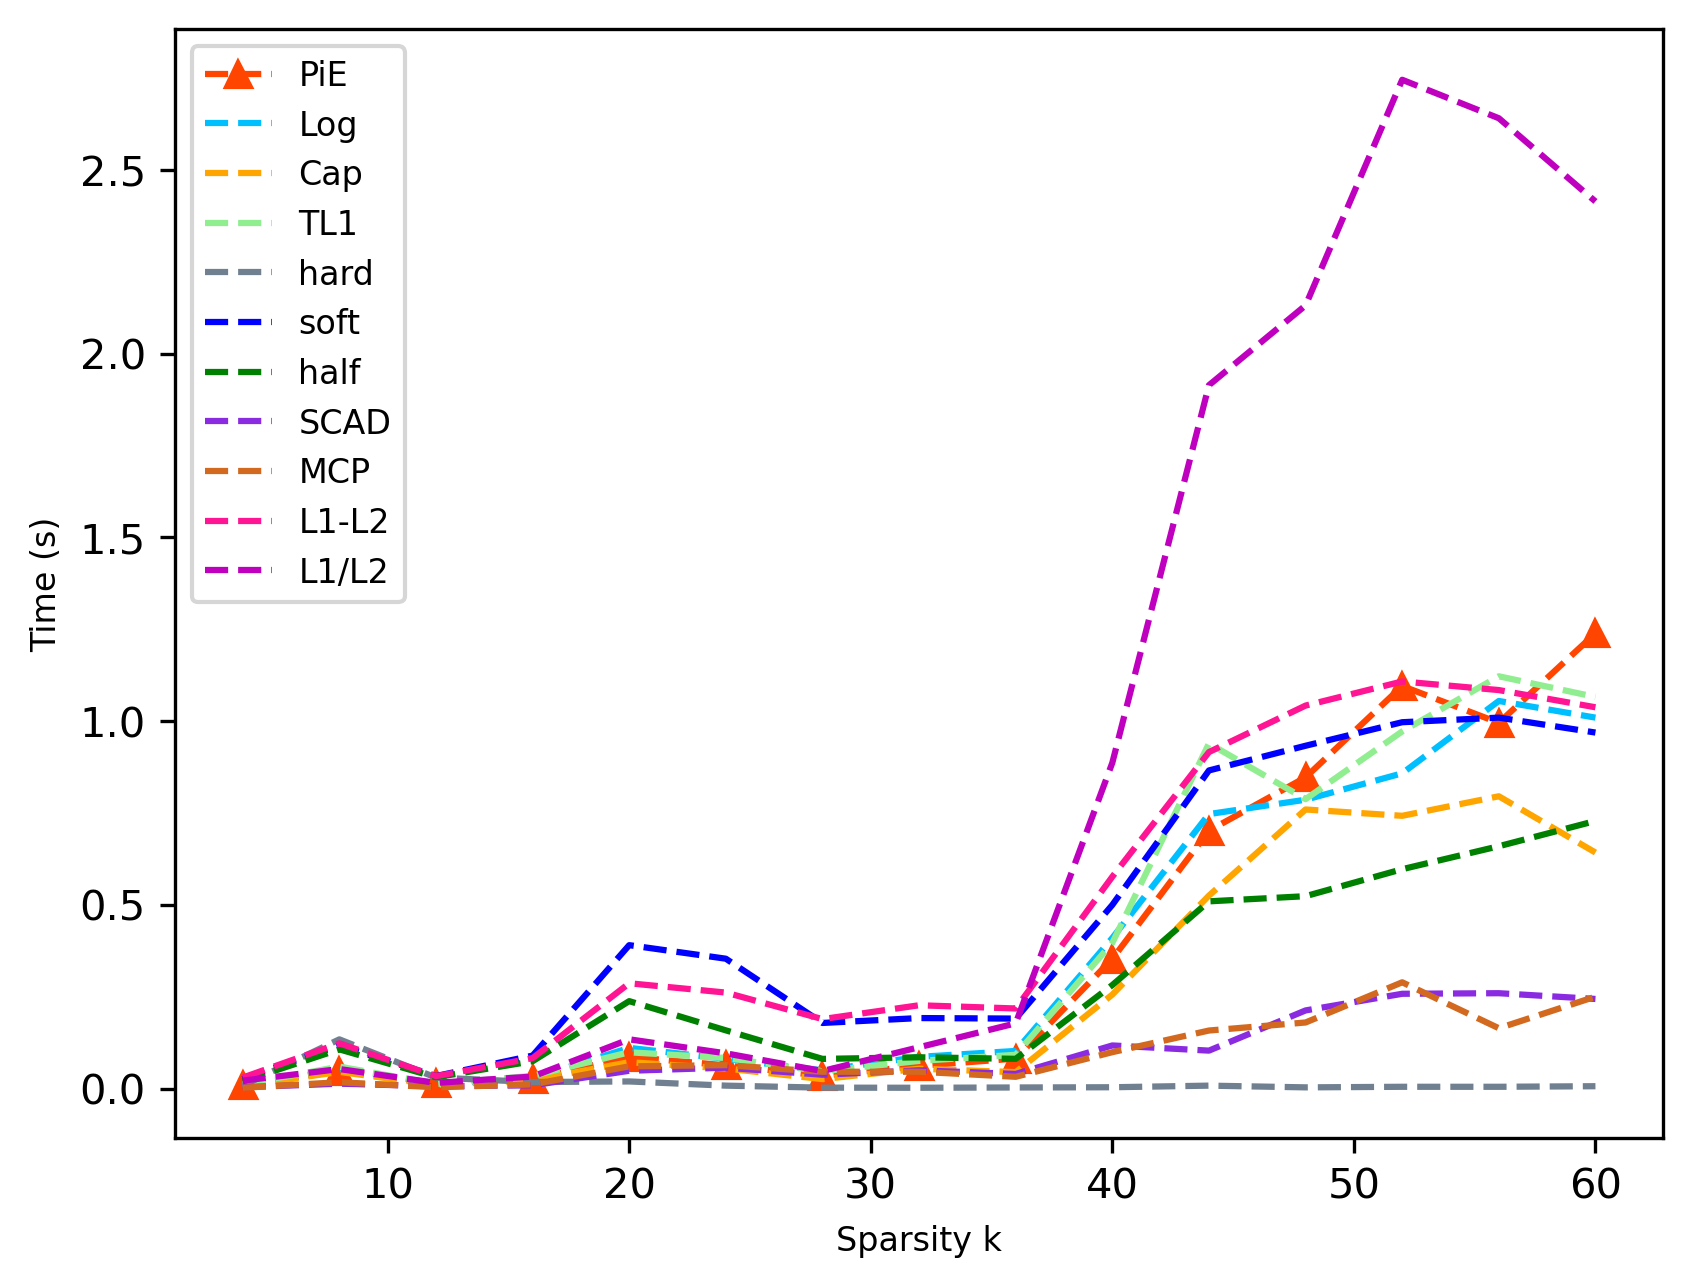

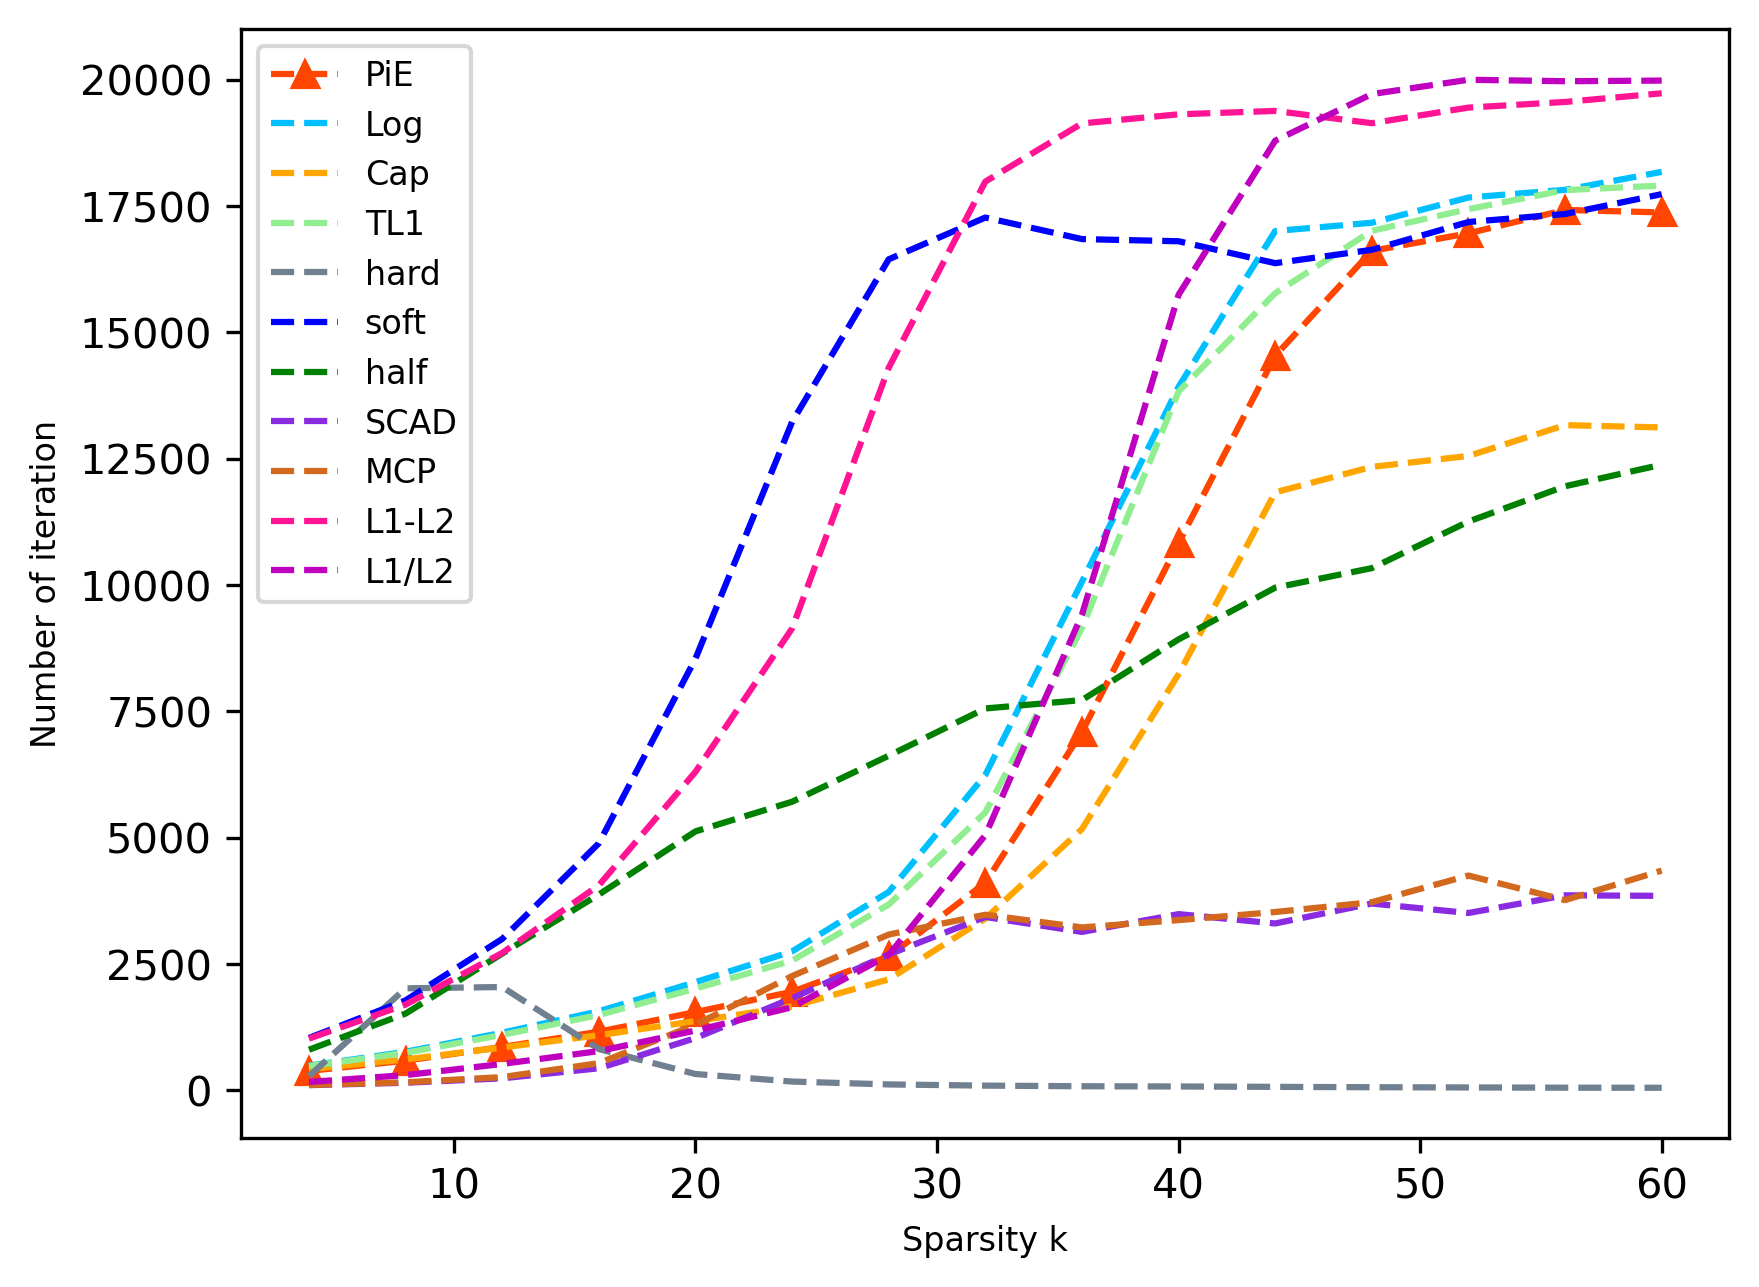

In [12]:
plt.rcParams['figure.dpi'] = 300 #分辨率
color_list = ['orangered','deepskyblue','orange','lightgreen','slategrey','blue','green',
              'blueviolet','chocolate','deeppink','m']
label_list = ['PiE','Log','Cap','TL1','hard','soft','half','SCAD','MCP','L1-L2','L1/L2']
mark_list = ['^',None,None,None,None,None,None,None,None,None,None]

plt.figure()
for i in range(success_99.shape[1]):
    plt.plot(k_list, success_99[:,i],label=label_list[i],color=f'{color_list[i]}', linestyle='--',marker =mark_list[i] )
plt.ylabel('Success rate',fontsize =8)
plt.xlabel("Sparsity k",fontsize =8)
plt.legend(fontsize =8)
plt.show()

plt.figure()
for i in range(avgtime_99.shape[1]):
    plt.plot(k_list, avgtime_99[:,i],label=label_list[i],color=f'{color_list[i]}', linestyle='--',marker =mark_list[i] )
plt.ylabel('Time (s)',fontsize =8)
plt.xlabel("Sparsity k",fontsize =8)
plt.legend(fontsize =8)
plt.show()

plt.figure()
for i in range(numiter_99.shape[1]):
    plt.plot(k_list, numiter_99[:,i],label=label_list[i],color=f'{color_list[i]}', linestyle='--',marker =mark_list[i] )
plt.ylabel('Number of iteration',fontsize =8)
plt.xlabel("Sparsity k",fontsize =8)
plt.legend(fontsize =8)
plt.show()

# 5 不同的算法对比

\begin{array}{|c|c|c|c|c|c|c|c|c|c|c|c|} \hline
Penalties & ISTA &iPiaon & DCA1 & DCA2 & Accelerated  \\ \hline
 &\lambda=0.05  &\lambda=0.05  &\lambda=0.001  &\lambda=0.001  &\lambda=0.02  \\  
  &\sigma=2  &\sigma=2  &\sigma=2 &\sigma=2 &\sigma=2 \\  
   Parameters        &\mu=0.99\!\frac{2}{\nu_{\max}+\frac{\lambda}{\sigma^2}}
           &\mu=0.99\!\frac{2}{\nu_{\max}+\frac{\lambda}{a^2}}
           &\mu=0.5\!\frac{2}{\nu_{\max}}
           &\mu=0.5\!\frac{2}{\nu_{\max}+\frac{2(a+1)\lambda}{a^2}}
           &\mu_1=0.8\!\frac{2}{\nu_{\max}+\frac{1}{a-1}}\\
           &-&-&-&-&\mu_2=0.99\!\frac{2}{\nu_{\max}+\frac{1}{a-1}}\\ \hline
\end{array}

In [6]:
sigma_ista = 2
Lambda_ista = 0.05

sigma_ipiano = 2
Lambda_ipiano = 0.05
rho_ipiano = Lambda_ipiano/(sigma_ipiano**2)
L_ipiano = max(np.linalg.norm(A,2)**2-rho_ipiano,rho_ipiano)
beta_ipiano = 0.99
alpha_ipiano = 0.99*(4*(1-beta_ipiano)/L_ipiano)

sigma_extrapolation = 2
Lambda_extrapolation = 0.001
rho_extrapolation = Lambda_extrapolation/(sigma_extrapolation**2)
alpha_extrapolation= 0.5*(2/np.linalg.norm(A,2)**2)

sigma_extrapolation2 = 2
Lambda_extrapolation2 = 0.001
rho_extrapolation2 = Lambda_extrapolation2/(sigma_extrapolation2**2)
alpha_extrapolation2= 0.5*(2/np.linalg.norm(A,2)**2)

sigma_accelerated = 2
Lambda_accelerated = 0.02
ax_accelerated = 0.8*(2/(max(e).real+Lambda_accelerated/(sigma_accelerated**2)))
ay_accelerated = 0.99*(2/(max(e).real+Lambda_accelerated/(sigma_accelerated**2)))

e,v = np.linalg.eig(A.T.dot(A))
mu_ista = 0.99*(2/(max(e).real+Lambda_ista/(sigma_ista**2)))

#beta_k
theta0 = 1
theta1 = 1
beta_k = []
for i in range(maxiter):
    beta_k.append((theta0 - 1)/theta1)
    theta0 = theta1
    theta1 = (1+np.sqrt(1+4*theta1**2))/2

k_list = np.linspace(4,60,15)
x_index = [i for i in range(n)]

avgtime = np.zeros((len(k_list),5))
Success = np.zeros((len(k_list),5))
numiter = np.zeros((len(k_list),5))

for index_k, k in enumerate(k_list):
    p = k/n
    
    total_time = np.zeros((1,5))
    total_num = np.zeros((1,5))
    
    for j in tqdm(range(100)):
        x_true = rand(n,1,p).toarray()
        x_true[x_true != 0 ] = 10*(x_true[x_true != 0 ]-0.5)
        b = A.dot(x_true)

        #pie ista
        t0 = time.process_time()
        temp = mu_ista*Lambda_ista/sigma_ista**2
        if temp<=1:
            x,num=ISTA(A,b,mu_ista,shrinkage_PiE_soft,sigma_ista,Lambda_ista,maxiter,error)
        else:
            x,num=ISTA(A,b,mu_ista,PiEProximalbyLambertWThreshold,sigma_ista,Lambda_ista,maxiter,error)
        if Error(x, x_true)<0.01:
            Success[index_k][0] += 0.01
        total_time[0][0] += time.process_time()-t0
        total_num[0][0] += num

        #pie ipiano
        t0 = time.process_time()
        temp_Lambda = Lambda_ipiano/(1+alpha_ipiano*rho_ipiano)
        temp = alpha_ipiano*temp_Lambda/sigma_ipiano**2
        if temp<=1:
            x,num = iPiano(A,b,rho_ipiano,beta_ipiano,alpha_ipiano,shrinkage_PiE_soft,sigma_ipiano,temp_Lambda,maxiter,error)
        else:
            x,num = iPiano(A,b,rho_ipiano,beta_ipiano,alpha_ipiano,PiEProximalbyLambertWThreshold,sigma_ipiano,temp_Lambda,maxiter,error)
        if Error(x, x_true)<0.01:
            Success[index_k][1] += 0.01
        total_time[0][1] += time.process_time()-t0
        total_num[0][1] += num

        #pie extrapolation
        t0 = time.process_time()
        temp_Lambda = Lambda_extrapolation/(1+alpha_extrapolation*rho_extrapolation)
        temp = alpha_extrapolation*temp_Lambda/sigma_extrapolation**2
        if temp <= 1:
            x,num = DCA1(A,b,rho_extrapolation,beta_k,alpha_extrapolation,shrinkage_PiE_soft,sigma_extrapolation,temp_Lambda,maxiter,error)
        else:
            x,num = DCA1(A,b,rho_extrapolation,beta_k,alpha_extrapolation,PiEProximalbyLambertWThreshold,sigma_extrapolation,temp_Lambda,maxiter,error)
        if Error(x, x_true)<0.01:
            Success[index_k][2] += 0.01
        total_time[0][2] += time.process_time()-t0
        total_num[0][2] += num
        
        #pie extrapolation2
        t0 = time.process_time()
        x,num = DCA2(A,b,rho_extrapolation2,beta_k,alpha_extrapolation2,shrinkage_soft,sigma_extrapolation2,Lambda_extrapolation2,maxiter,error)
        if Error(x, x_true)<0.01:
            Success[index_k][3] += 0.01
        total_time[0][3] += time.process_time()-t0
        total_num[0][3] += num
        
        #pie accelerated
        shrinkage_list=[]
        t0 = time.process_time()

        temp1 = ay_accelerated*Lambda_accelerated/sigma_accelerated**2
        if temp1<=1:
            shrinkage1 = shrinkage_PiE_soft
        else:
            shrinkage1 = PiEProximalbyLambertWThreshold
        temp2 = ax_accelerated*Lambda_accelerated/sigma_accelerated**2
        if temp2<=1:
            shrinkage2 = shrinkage_PiE_soft
        else:
            shrinkage2 = PiEProximalbyLambertWThreshold
        x,num = Accelerated(A,b,ax_accelerated,ay_accelerated,shrinkage1,shrinkage2,sigma_accelerated,Lambda_accelerated,maxiter,error)
        if Error(x, x_true)<0.01:
            Success[index_k][4] += 0.01
        total_time[0][4] += time.process_time()-t0
        total_num[0][4] += num
    avgtime[index_k] = total_time/100
    numiter[index_k] = total_num/100

100%|██████████| 100/100 [18:34<00:00, 11.14s/it]


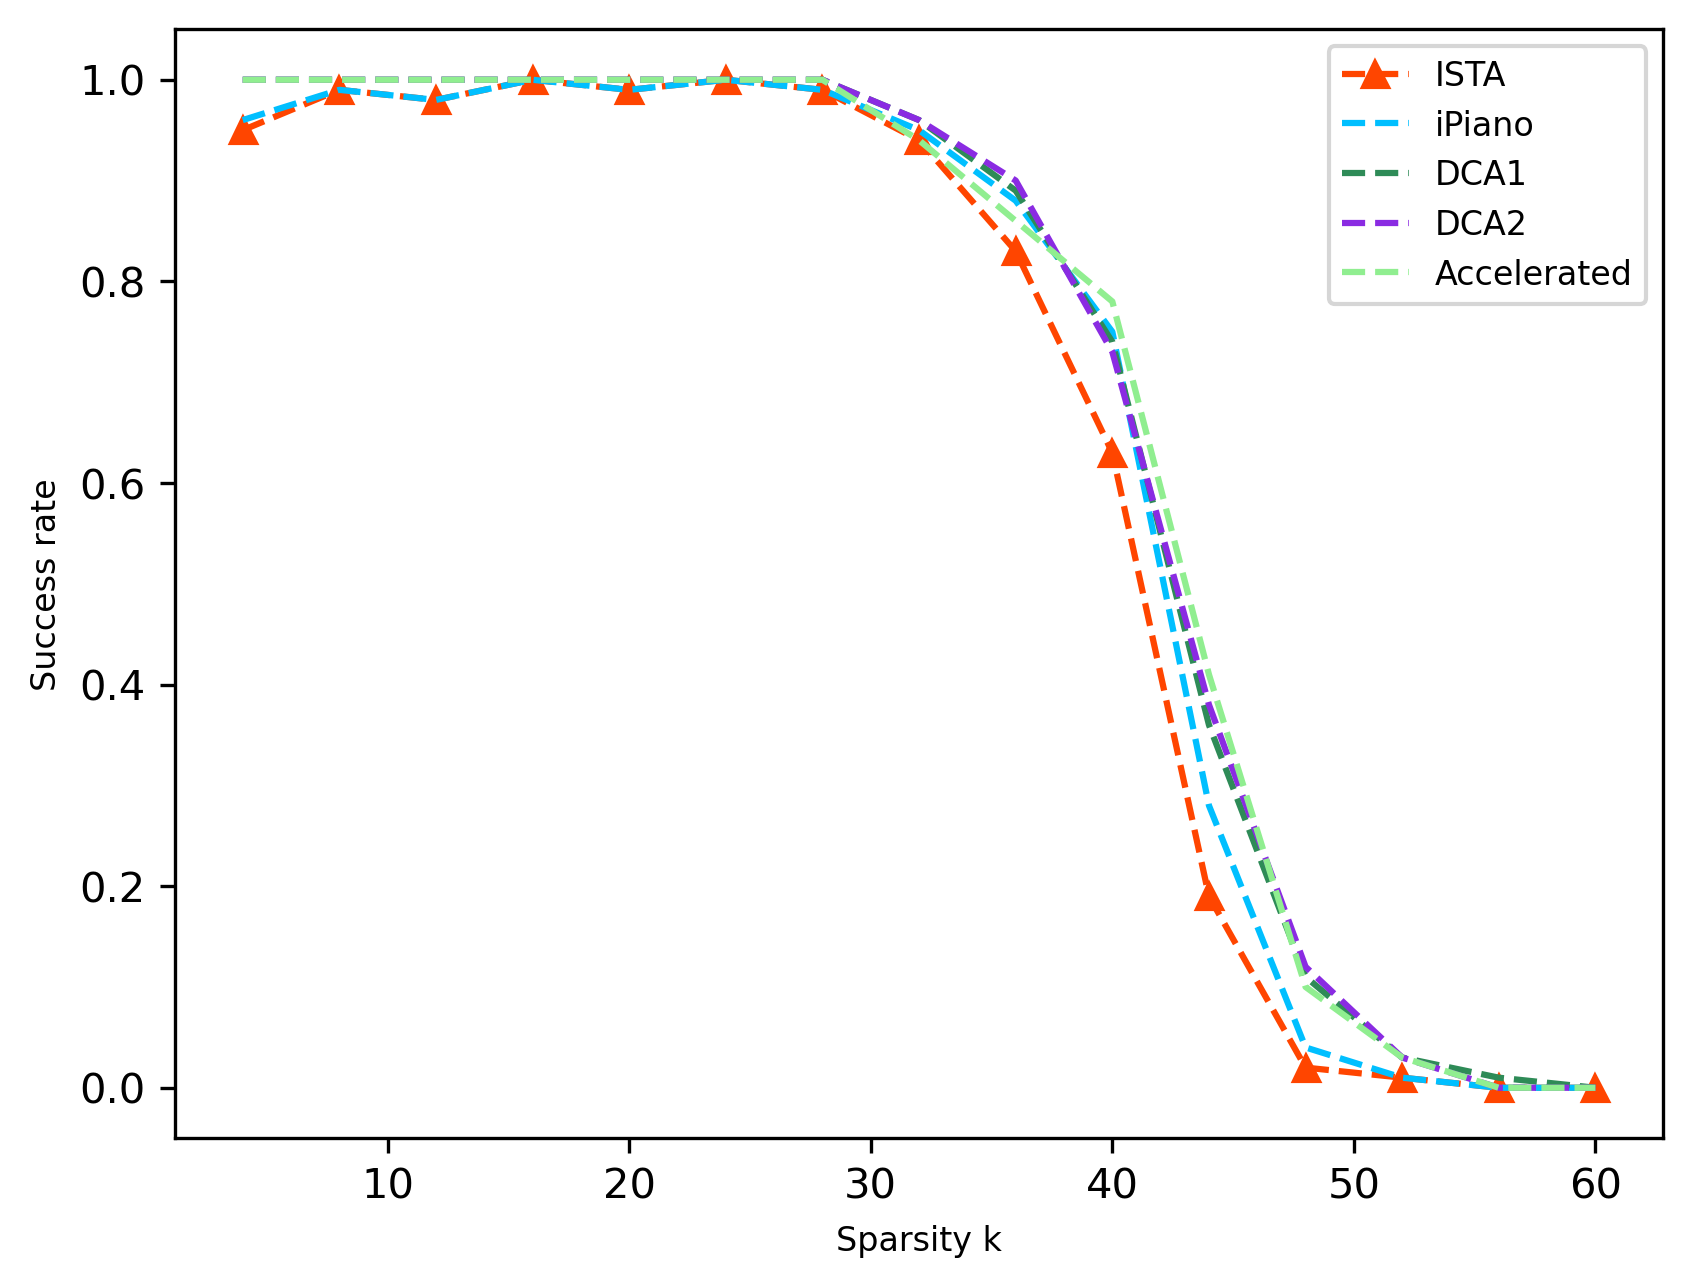

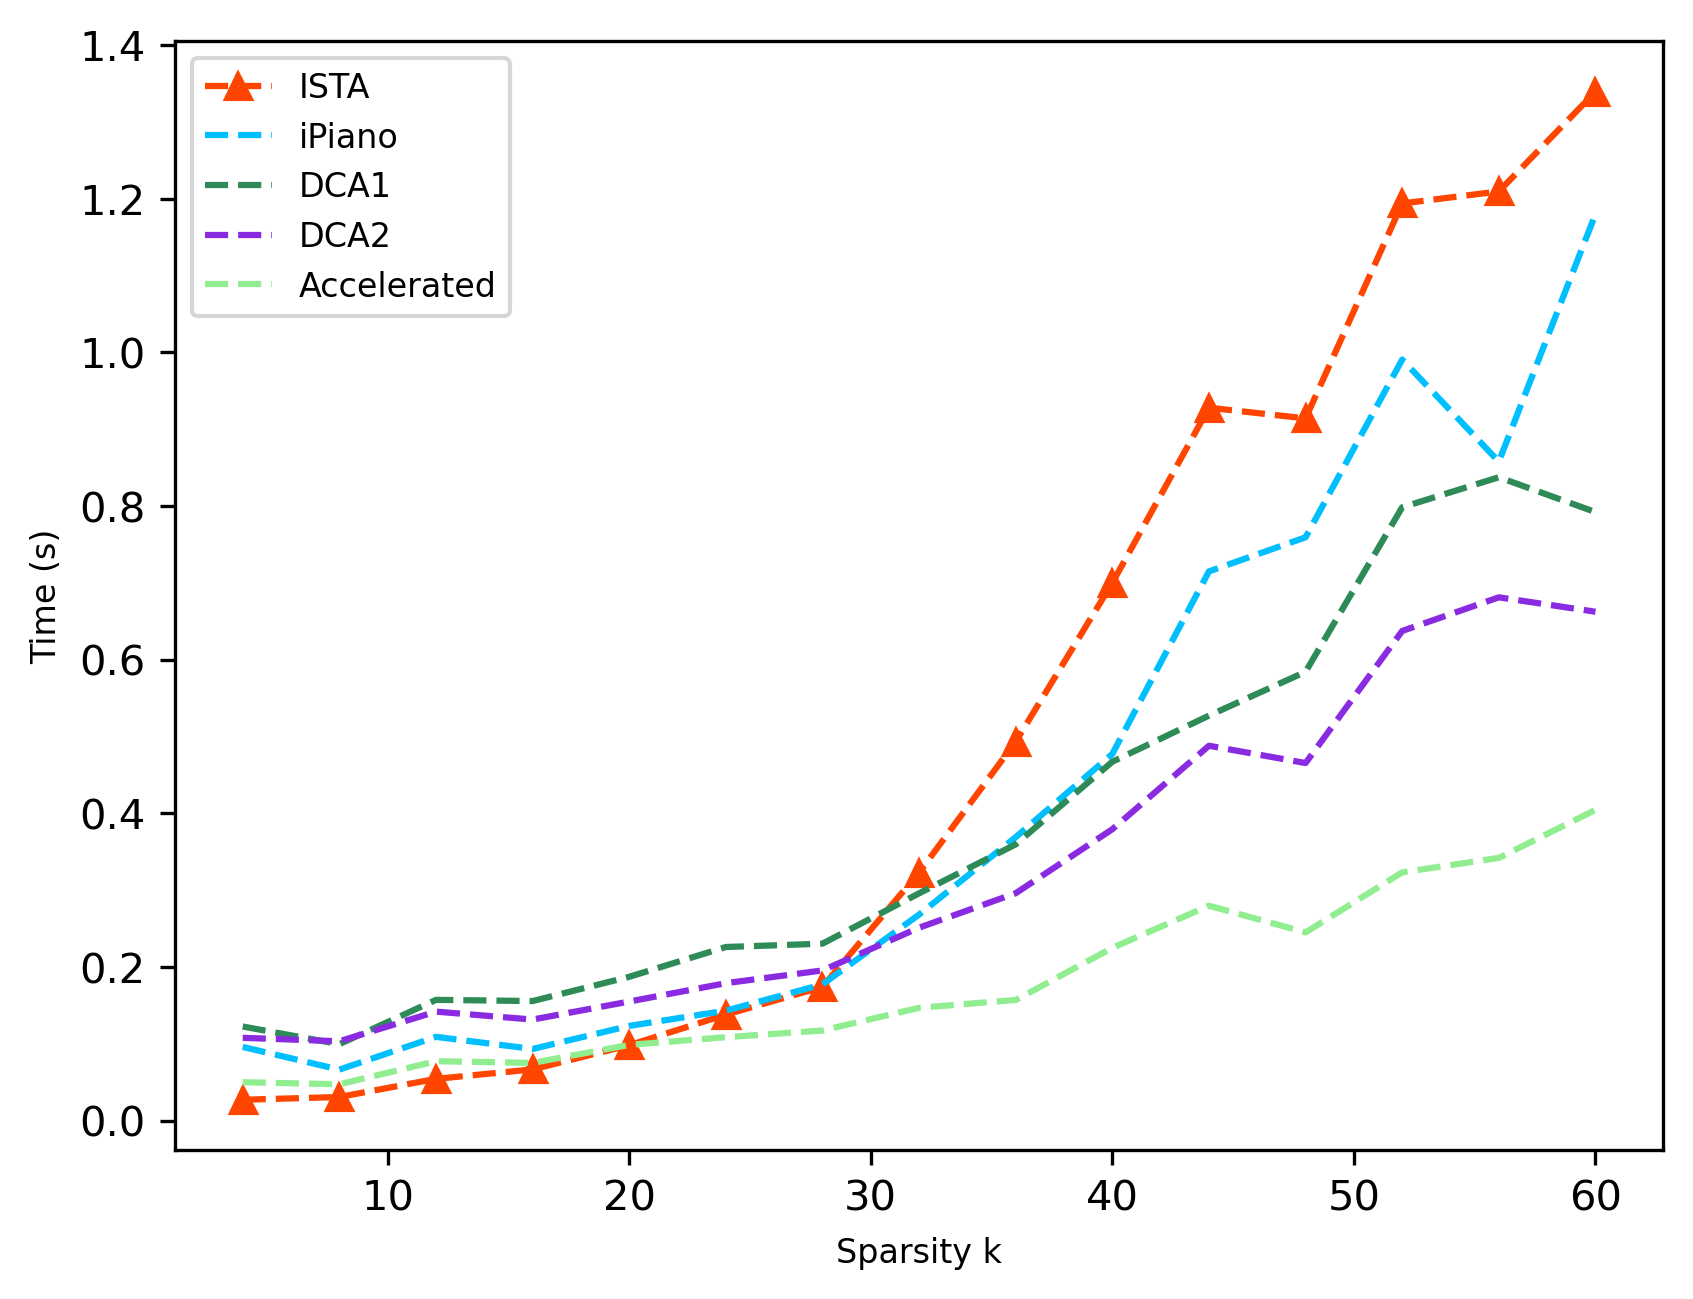

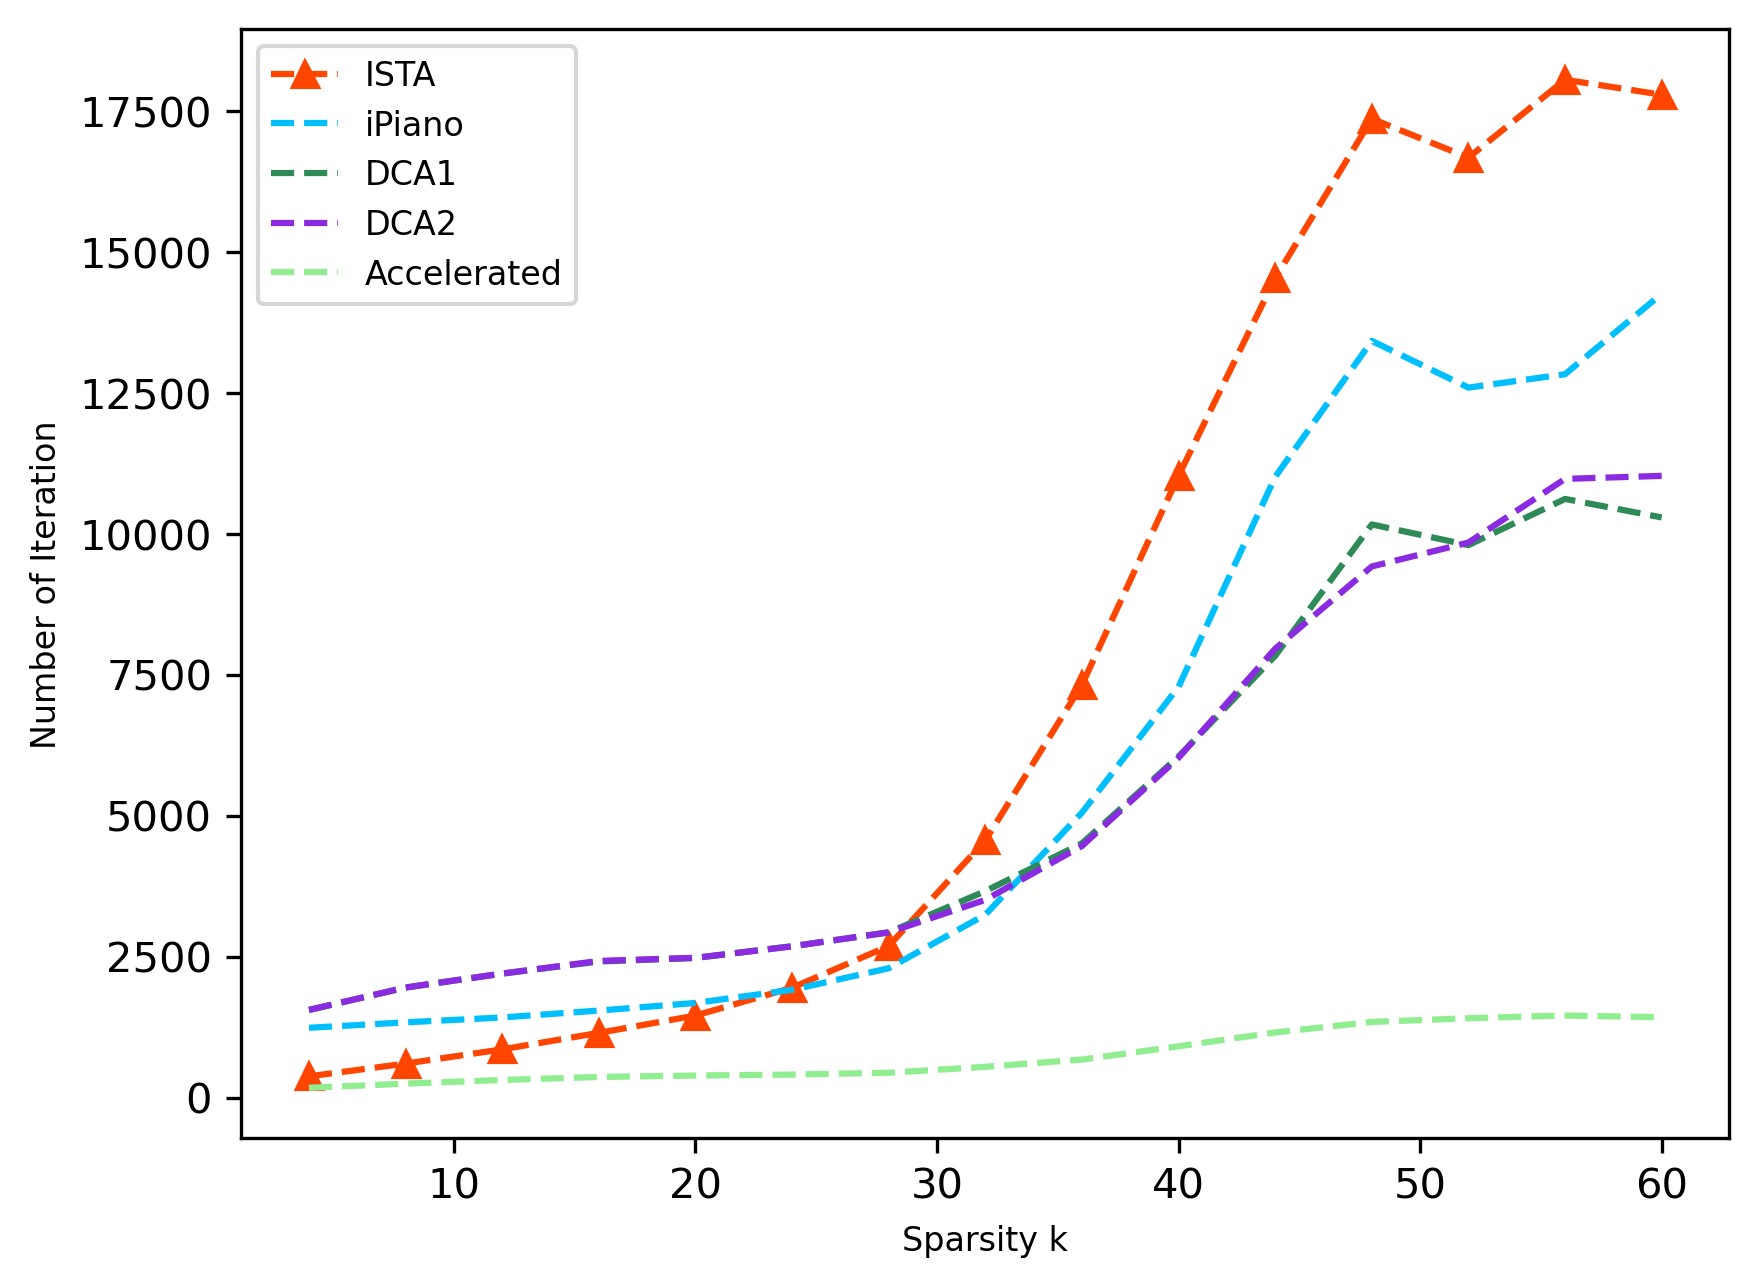

In [30]:
plt.rcParams['figure.dpi'] = 300 #分辨率
color_list = ['orangered','deepskyblue','seagreen','blueviolet','lightgreen']
label_list = ['ISTA','iPiano','DCA1','DCA2','Accelerated']
mark_list = ['^',None,None,None,None]

plt.figure()
for i in range(Success.shape[1]):
    plt.plot(k_list, Success[:,i],label=label_list[i],color=f'{color_list[i]}', linestyle='--',marker =mark_list[i] )
plt.ylabel('Success rate',fontsize =8)
plt.xlabel("Sparsity k",fontsize =8)
plt.legend(fontsize =8)
plt.show()

plt.figure()
for i in range(avgtime.shape[1]):
    plt.plot(k_list, avgtime[:,i],label=label_list[i],color=f'{color_list[i]}', linestyle='--',marker =mark_list[i] )
plt.ylabel('Time (s)',fontsize =8)
plt.xlabel("Sparsity k",fontsize =8)
plt.legend(fontsize =8)
plt.show()

plt.figure()
for i in range(numiter.shape[1]):
    plt.plot(k_list, numiter[:,i],label=label_list[i],color=f'{color_list[i]}', linestyle='--',marker =mark_list[i] )
plt.ylabel('Number of Iteration',fontsize =8)
plt.xlabel("Sparsity k",fontsize =8)
plt.legend(fontsize =8)
plt.show()

# 5 练习

本实验计算非常耗时（随机高斯矩阵$128\times1024$;稀疏4，8,...60; 成功率是重复了100次算重构的成功比；稀疏罚函数11个，算法5个）。若想自己运行程序快速得到数值结果，建议如下：矩阵大小为$64\times256$，稀疏度4,8,12,16,20,24；成功率是重复了20次算重构的成功比；稀疏罚函数1-2个，算法1-2个。

本实验不参与竞赛排名,程序无需线上运行，直接输出已有保存的图片结果即可。